# Train Regression Models for Risk Prediction
This notebook loads `final_data.csv` and trains regressors to predict `Risk` as a continuous score (0.0 to 1.0). It includes EDA, preprocessing, model training, evaluation, and model saving.

In [ ]:
# Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [22]:
# Load data
import os
DATA_PATH = 'final_data.csv'
assert os.path.exists(DATA_PATH), f"{DATA_PATH} not found in notebook folder"
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()

Shape: (242457, 6)


,Temperature_Room,Humidity_Room,Pressure_Room,CO_Room,CO2_Room,Risk
0,28.2,47.0,1000,0.54,926.0,0.3
1,28.2,48.1,1000,0.31,821.0,0.3
2,27.7,48.4,1000,0.10,599.0,0.3
3,27.3,47.9,1000,0.13,919.0,0.3
4,27.0,49.4,1000,0.00,737.0,0.3


In [23]:
# Quick data overview
print('\nData types:')
print(df.dtypes)
print('\nMissing values per column:')
print(df.isnull().sum())
print('\nTarget distribution:')
print(df['Risk'].value_counts(dropna=False))

# Describe numeric columns
df.describe().T


Data types:
Temperature_Room    float64
Humidity_Room       float64
Pressure_Room         int64
CO_Room             float64
CO2_Room            float64
Risk                float64
dtype: object

Missing values per column:
Temperature_Room    0
Humidity_Room       0
Pressure_Room       0
CO_Room             0
CO2_Room            0
Risk                0
dtype: int64

Target distribution:
Risk
0.00    162480
0.80     49285
0.30     16170
0.96     11979
1.00      2428
0.36       115
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
Temperature_Room,242457.0,28.652563,2.617902,20.4,26.9,28.70,30.50,35.20
Humidity_Room,242457.0,42.788155,5.515768,32.8,38.8,42.80,46.50,69.80
Pressure_Room,242457.0,1000.000000,0.000000,1000.0,1000.0,1000.00,1000.00,1000.00
CO_Room,242457.0,0.578633,2.679186,0.0,0.0,0.18,0.63,216.81
CO2_Room,242457.0,640.614233,173.448201,0.0,532.0,639.00,760.00,2628.00
Risk,242457.0,0.240242,0.366047,0.0,0.0,0.00,0.80,1.00


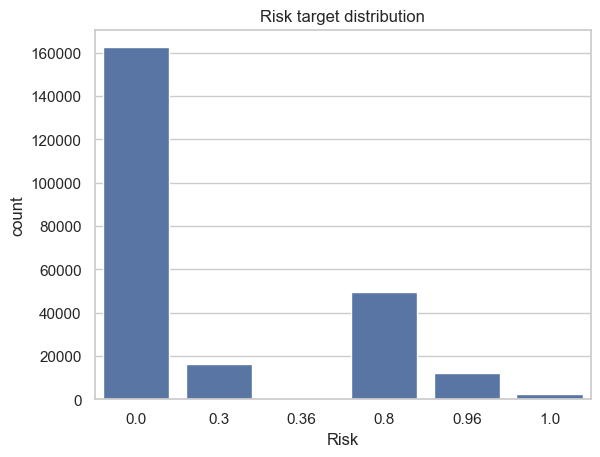

In [24]:
# EDA plots for key features
features_to_plot = ['Temperature','Humidity','Pressure','CO','CO2']
for col in features_to_plot:
    if col in df.columns:
        plt.figure(figsize=(10,3))
        plt.subplot(1,2,1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Histogram of {col}')
        plt.subplot(1,2,2)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

# Target count plot
if 'Risk' in df.columns:
    sns.countplot(x='Risk', data=df)
    plt.title('Risk target distribution')
    plt.show()

In [25]:
# Preprocess features and target
features = ['Temperature_Room','Humidity_Room','Pressure_Room','CO_Room','CO2_Room']
for f in features:
    if f not in df.columns:
        raise ValueError(f"Feature {f} not found in data")

# Convert target to float (regression - predict continuous Risk score)
y = df['Risk'].astype(float).copy()
X = df[features].copy()

# Impute and scale
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_proc = preprocessor.fit_transform(X)
print('Preprocessed features shape:', X_proc.shape)
print('Target (Risk) statistics:')
print(y.describe())

Preprocessed features shape: (242457, 5)
Target (Risk) statistics:
count    242457.000000
mean          0.240242
std           0.366047
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max           1.000000
Name: Risk, dtype: float64


In [26]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, random_state=42)
print('Train set statistics:')
print(pd.Series(y_train).describe())
print('\nTest set statistics:')
print(pd.Series(y_test).describe())

Train set statistics:
count    193965.000000
mean          0.240252
std           0.366014
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max           1.000000
Name: Risk, dtype: float64

Test set statistics:
count    48492.000000
mean         0.240200
std          0.366182
min          0.000000
25%          0.000000
50%          0.000000
75%          0.800000
max          1.000000
Name: Risk, dtype: float64


In [42]:
# Train regression models to predict continuous Risk score (0.0 to 1.0)
# Create sample weights to penalize misses on high-risk scores
# Weight higher risk values more so model captures full range
sample_weights = 1.0 + 4.0 * y_train.values  # Range: 1.0 to ~5.0 based on risk level

from sklearn.linear_model import LinearRegression
models = {
    'LinearRegression': LinearRegression(),  # No regularization - allows full range
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, 
                                          max_depth=13, min_samples_leaf=5)  # Tighter constraints to prevent overfitting
}

fitted = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train, sample_weight=sample_weights)
    fitted[name] = model
print('Done')

Training LinearRegression...
Training RandomForest...
Done


In [43]:
# Evaluate regression models on test set
results = {}
for name, model in fitted.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    res = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }
    results[name] = res

import pandas as _pd
results_df = _pd.DataFrame(results).T
print('*** Regression Metrics ***')
print('MAE/RMSE (lower is better) | R² (higher is better, 1.0 = perfect)')
print(results_df)

*** Regression Metrics ***
MAE/RMSE (lower is better) | R² (higher is better, 1.0 = perfect)
                       MAE      RMSE        R2
LinearRegression  0.282808  0.347633  0.098725
RandomForest      0.069446  0.157305  0.815456


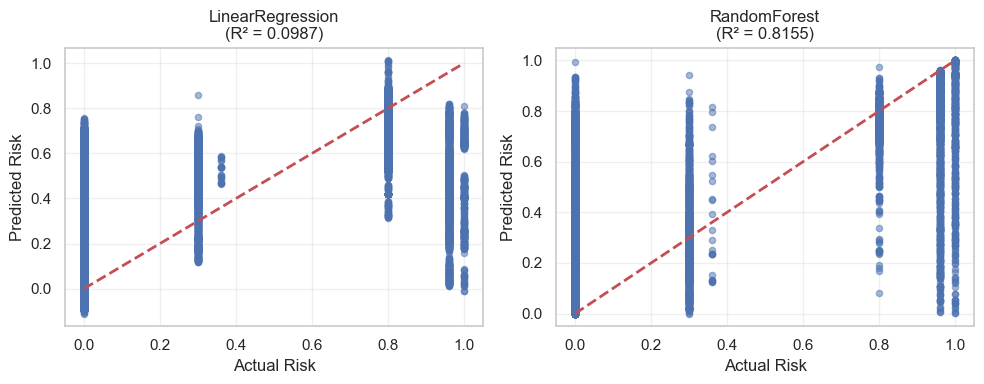

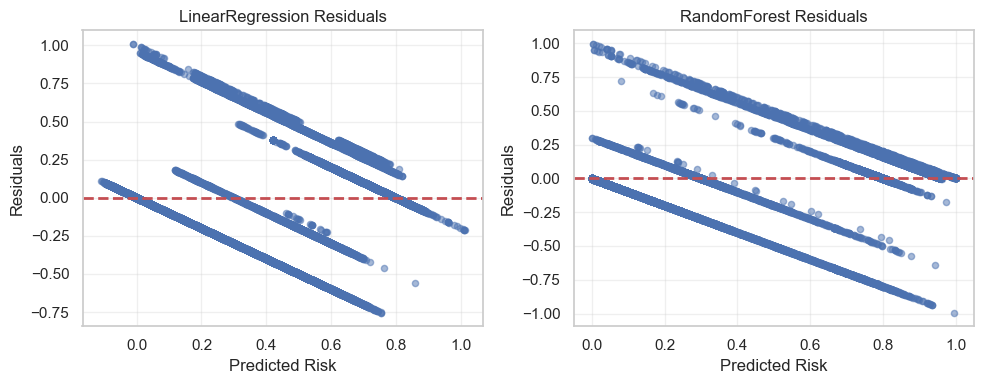

In [44]:
# Predictions vs Actual scatter plots
plt.figure(figsize=(10,4))
for i, (name, model) in enumerate(fitted.items()):
    plt.subplot(1,2,i+1)
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.5, s=20)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    r2 = r2_score(y_test, y_pred)
    plt.xlabel('Actual Risk')
    plt.ylabel('Predicted Risk')
    plt.title(f'{name}\n(R² = {r2:.4f})')
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residual plots
plt.figure(figsize=(10,4))
for i, (name, model) in enumerate(fitted.items()):
    plt.subplot(1,2,i+1)
    y_pred = model.predict(X_test)
    residuals = y_test.values - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5, s=20)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted Risk')
    plt.ylabel('Residuals')
    plt.title(f'{name} Residuals')
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

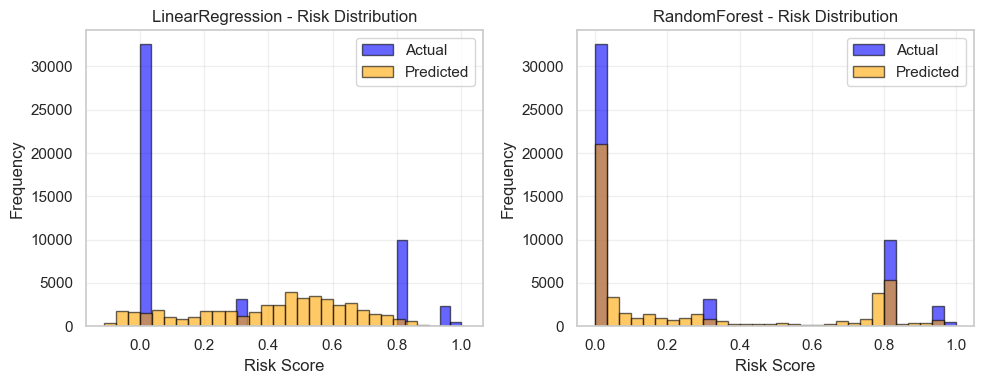

In [45]:
# Distribution of predictions vs actual values
plt.figure(figsize=(10,4))
for i, (name, model) in enumerate(fitted.items()):
    plt.subplot(1,2,i+1)
    y_pred = model.predict(X_test)
    plt.hist(y_test.values, bins=30, alpha=0.6, label='Actual', color='blue', edgecolor='black')
    plt.hist(y_pred, bins=30, alpha=0.6, label='Predicted', color='orange', edgecolor='black')
    plt.xlabel('Risk Score')
    plt.ylabel('Frequency')
    plt.title(f'{name} - Risk Distribution')
    plt.legend()
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

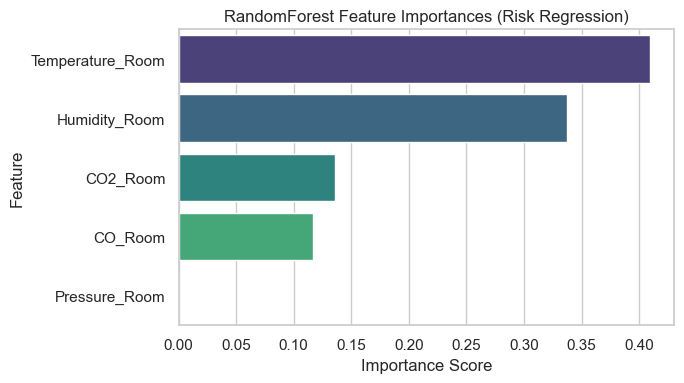

In [46]:
# Feature importance for RandomForest regressor
if 'RandomForest' in fitted:
    rf = fitted['RandomForest']
    try:
        importances = rf.feature_importances_
        fi = pd.Series(importances, index=features).sort_values(ascending=False)
        plt.figure(figsize=(7,4))
        sns.barplot(x=fi.values, y=fi.index, palette='viridis')
        plt.title('RandomForest Feature Importances (Risk Regression)')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Could not compute feature importances:', e)

In [ ]:
# Save best model by R² score on test set
best_name = None
best_r2 = -float('inf')
for name, model in fitted.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: R² = {r2:.4f}")
    if r2 > best_r2:
        best_r2 = r2
        best_name = name

print(f'\nBest model: {best_name} (R² = {best_r2:.4f})')
if best_name is not None:
    model_path = 'model.joblib'
    joblib.dump(fitted[best_name], model_path)
    print(f'Saved {best_name} to {model_path}')

# Notes

- **Regression Approach**: This notebook trains regressors to predict Risk as a continuous value (0.0 to 1.0).
- **Metrics**: R² = 1 (perfect), MAE/RMSE = 0 (perfect). Higher R² and lower errors are better.
- Run cells top-to-bottom. If `final_data.csv` updates, re-run from the data load cell.
- The saved `model.joblib` contains only the trained model. Use the `preprocessor` pipeline from cell 6 when making new predictions.